In [1]:
import numpy as np
from sklearn import datasets
from tqdm import tqdm
from time import sleep
import seaborn as sns
import matplotlib.pyplot as plt

# Exercise 2

## Task 3: Application

### Derivations:

ReLU Layer:

\begin{align*}
\tilde{Z_l} = Z_{l-1}\\
\\
\Phi_l(\tilde{Z_l}) = ReLU(\tilde{Z_l})\\
\\
g_{l}^{(downstream)} = g_l^{(upstream)}\cdot\frac{\partial Z_l}{\partial Z_{l-1}} = g_l^{(upstream)}\cdot \Theta(z_{l-1})
\end{align*}

Linear Layer:

\begin{align*}
\tilde{Z_l} = B_l \cdot Z_{l-1} + b_l\\
\\
Z_l = \Phi_l(\tilde{Z_l}) = \tilde{Z_l}\\
\\
g_{l}^{(downstream)} = g_l^{(upstream)}\cdot\frac{\partial Z_l}{\partial Z_{l-1}} = g_l^{(upstream)}\cdot B_l^T\\
\\
\frac{\partial Loss}{\partial B_l} = \frac{\partial Loss}{\partial Z_l} \cdot \frac{\partial Z_l}{\partial B_l} = g_l^{(upstream)} \cdot Z_{l-1}\\
\\
\frac{\partial Loss}{\partial b_l} = \frac{\partial Loss}{\partial Z_l} \cdot \frac{\partial Z_l}{\partial b_l} = g_l^{(upstream)}
\end{align*}

Output Layer:

\begin{align*}
\tilde{Z_l} = Z_{l-1}\\
Z_l = \Phi_l(\tilde{Z_l}) = Softmax(\tilde{Z_l})\\
\\
g_{lk}^{(downstream)} = Z_{lk} - 1 \; if\; k=Y^*, Z_{lk} \;else \\
\\
\end{align*}

### Completed Code:

<div style="color:green;font-weight:bold">

## Style Comment:
Try to keep lines shorter (I had to scroll horizontally here).

# Layer Comments:

## ReLU:
Good. `np.maximum` is slightly more readable than `np.where`.

## Output:
Semantically good. Casting to `tuple` for indexing is unnecessary.
You also do not divide the gradient by the batch size (more on this under `LinearLayer`).

Better: you can use `np.eye` to generate one-hot encodings instead of indexing.
The lines

```
ones = np.zeros(np.shape(predicted_posteriors))
ones[tuple(np.array([np.arange(len(true_labels)), true_labels]))] = 1
```

are then replaced by

```
one_hot = np.eye(self.n_classes)[true_labels]
```

which is equivalent, but more readable. But the sample solution also did not do this.

Another thing to note is that you compute `np.exp(self.input)` twice in `forward()`,
which is slow especially for large inputs. Note that python does not optimize this away.
Instead cache the result: `exp = np.exp(self.input)` and then use `exp` in both the numerator
and denominator of the `softmax`. Transposing the arrays is also not necessary, if you introduce a new
axis in the sum, e.g.:

```
def softmax(x, axis=None):
    ex = np.exp(x)
    sums = np.sum(ex, axis=axis)

    if axis is not None:
        # shape must be broadcastable
        shape = list(ex.shape)
        shape[axis] = -1

        return ex / sums.reshape(shape)

    # sums is scalar
    return ex / sums
```


## Linear:

The sample solution downscales the initial weights' $\sigma$, but this is not strictly necessary.

`forward()`: Fine. I am not sure if you intended this, but `self.input = input[:]`
copies the array, whereas `self.input = input` only copies the reference.
This is not wrong, however, you only create a copy in this layer.
In the others, the input is only reference-copied. This may yield confusing results
for people who use your code without knowing such implementation details. If it is intentional, use the
`copy()` method for code explicitness.

`backward()`: Again, you can avoid transposing twice.

Using `np.mean` instead of `np.sum` may lead to
scaling issues in the gradient for this or other layers.
You should either divide the initial `upstream_gradient`
by the batch size in the `OutputLayer` or relay this to
the `learning_rate`, with the former preferred
(makes the gradient calculation independent of changes in batch size).

This way you are introducing a stacking $\frac{1}{N^{l - 1}}$ factor to the
gradient with every linear layer $l$. Your model may still converge
(gradient points in the correct direction), but it could be slower, or
arrive at a bad minimum, when the gradient is too small, especially for the first few layers.

Same applies to dividing by `np.shape(...)[0]`.

## MLP:

Good. I personally find `reversed(...)` to be more readable than `[::-1]` and this is also more
memory-efficient since it is an iterator, whereas `[::-1]` clones the whole list.

You should <i>not</i> call `layer.update` in the `backward` function. That is what the `MLP.update`
function is for. This way, you will update twice whenever `MLP.update` is called, since this also calls
`layer.update`.

</div>

In [2]:
def Net_Test(Size):                     #Benchmarks
    for t in np.arange(0,250,5):        #Benchmarks
        ####################################

        class ReLULayer(object):
            def forward(self, input):
                # remember the input for later backpropagation
                self.input = input
                # return the ReLU of the input
                relu = np.where(input > 0, input, 0) # ReLu is identity for x > 0 and zero otherwise
                return relu

            def backward(self, upstream_gradient):
                # compute the derivative of ReLU from upstream_gradient and the stored input
                downstream_gradient = upstream_gradient * np.where(self.input > 0, 1, 0) # Computing the gradient following the equations above
                return downstream_gradient

            def update(self, learning_rate):
                pass # ReLU is parameter-free

        ####################################

        class OutputLayer(object):
            def __init__(self, n_classes):
                self.n_classes = n_classes

            def forward(self, input):
                # remember the input for later backpropagation
                self.input = input
                # return the softmax of the input
                softmax = np.exp(self.input).T / np.sum(np.exp(self.input), axis = 1) # Computing the Softmax Output for each output node
                return softmax.T

            def backward(self, predicted_posteriors, true_labels):
                # return the loss derivative with respect to the stored inputs
                # (use cross-entropy loss and the chain rule for softmax,
                #  as derived in the lecture)
                ones = np.zeros(np.shape(predicted_posteriors))                         #computing the  gradient of the softmax output according
                ones[tuple(np.array([np.arange(len(true_labels)), true_labels]))] = 1   #to the equation above which was derived in the lecture
                downstream_gradient = predicted_posteriors - ones
                return downstream_gradient

            def update(self, learning_rate):
                pass # softmax is parameter-free

        ####################################

        class LinearLayer(object):
            def __init__(self, n_inputs, n_outputs):
                self.n_inputs  = n_inputs
                self.n_outputs = n_outputs
                # randomly initialize weights and intercepts
                self.B = np.random.normal(size=(n_inputs, n_outputs))
                self.b = np.random.normal(size=n_outputs)
                #print(np.shape(self.b))

            def forward(self, input):
                # remember the input for later backpropagation
                self.input = input[:]
                # compute the scalar product of input and weights
                # (these are the preactivations for the subsequent non-linear layer)
                #print("weights:", np.shape(self.B))
                #print("input shape:", np.shape(self.input))
                #print(np.shape(self.b))
                preactivations = np.dot(self.input, self.B) + self.b    #computing the preactivation according to the equation above
                #print("output shape:", np.shape(preactivations))
                return preactivations

            def backward(self, upstream_gradient):
                # compute the derivative of the weights from
                # upstream_gradient and the stored input

                # the gradient with respect to B_l and b_l are averaged over the batch
                self.grad_b = np.mean(upstream_gradient, axis=0)    #computing the gradient of the bias according to the equation above
                self.grad_B = 1 / np.shape(upstream_gradient)[0] * np.dot(upstream_gradient.T,self.input).T  #computing the gradient of the weights
                                                                                                            #according to the equations above

                # compute the downstream gradient to be passed to the preceding layer
                downstream_gradient = np.dot(upstream_gradient,self.B.T) #computing the downstream gradient according to the equation above
                return downstream_gradient

            def update(self, learning_rate):
                # update the weights by batch gradient descent
                self.B = self.B - learning_rate * self.grad_B
                self.b = self.b - learning_rate * self.grad_b

        ####################################

        class MLP(object):
            def __init__(self, n_features, layer_sizes):
                # constuct a multi-layer perceptron
                # with ReLU activation in the hidden layers and softmax output
                # (i.e. it predicts the posterior probability of a classification problem)
                #
                # n_features: number of inputs
                # len(layer_size): number of layers
                # layer_size[k]: number of neurons in layer k
                # (specifically: layer_sizes[-1] is the number of classes)
                self.n_layers = len(layer_sizes)
                self.layers   = []

                # create interior layers (linear + ReLU)
                n_in = n_features
                for n_out in layer_sizes[:-1]:
                    self.layers.append(LinearLayer(n_in, n_out))
                    self.layers.append(ReLULayer())
                    n_in = n_out

                # create last linear layer + output layer
                n_out = layer_sizes[-1]
                self.layers.append(LinearLayer(n_in, n_out))
                self.layers.append(OutputLayer(n_out))

            def forward(self, X):
                # X is a mini-batch of instances
                batch_size = X.shape[0]
                # flatten the other dimensions of X (in case instances are images)
                X = X.reshape(batch_size, -1)
                #print("forward propagation")
                # compute the forward pass
                # (implicitly stores internal activations for later backpropagation)
                result = X
                for layer in self.layers:
                    result = layer.forward(result)
                return result

            def backward(self, predicted_posteriors, true_classes):
                # perform backpropagation w.r.t. the prediction for the latest mini-batch X
                #print("backward propagation")
                upstream_gradient = self.layers[-1].backward(predicted_posteriors, true_classes)        #compute the downstream gradient of the output layer
                for layer in self.layers[:-1][::-1]:                        #Iterate through the remaining layers from end to start
                    upstream_gradient = layer.backward(upstream_gradient)   #pass the downstream gradient as upstream gradient for the next layer
                    layer.update(learning_rate)                             #update the layer if necessary

            def update(self, X, Y, learning_rate):
                posteriors = self.forward(X)
                self.backward(posteriors, Y)
                for layer in self.layers:
                    layer.update(learning_rate)

            def train(self, x, y, n_epochs, batch_size, learning_rate):
                N = len(x)
                n_batches = N // batch_size
                for i in tqdm(range(n_epochs)):
                    sleep(1.e-40)
                    #print("Epoch:", i)
                    # reorder data for every epoch
                    # (i.e. sample mini-batches without replacement)
                    permutation = np.random.permutation(N)

                    for batch in range(n_batches):
                        # create mini-batch
                        start = batch * batch_size
                        x_batch = x[permutation[start:start+batch_size]]
                        y_batch = y[permutation[start:start+batch_size]]

                        # perform one forward and backward pass and update network parameters
                        self.update(x_batch, y_batch, learning_rate)

        ##################################

        if __name__=="__main__":

            # set training/test set size
            N = 2000

            # create training and test data
            X_train, Y_train = datasets.make_moons(N, noise=0.05)
            X_test,  Y_test  = datasets.make_moons(N, noise=0.05)
            n_features = 2
            n_classes  = 2

            # standardize features to be in [-1, 1]
            offset  = X_train.min(axis=0)
            scaling = X_train.max(axis=0) - offset
            X_train = ((X_train - offset) / scaling - 0.5) * 2.0
            X_test  = ((X_test  - offset) / scaling - 0.5) * 2.0

            # set hyperparameters (play with these!)
            layer_sizes = [Size, Size, n_classes]
            n_epochs = t
            batch_size = 200
            learning_rate = 0.05

            # create network
            network = MLP(n_features, layer_sizes)

            # train
            network.train(X_train, Y_train, n_epochs, batch_size, learning_rate)

            # test
            predicted_posteriors = network.forward(X_test)
            # determine class predictions from posteriors by winner-takes-all rule
            predicted_classes = np.argmax(predicted_posteriors, axis = 1) #prediction = class with highest posterior
            # compute and output the error rate of predicted_classes
            error_rate = np.mean(np.where(predicted_classes == Y_test, 0,1)) #error rate = mean of being wrong
            print("error rate:", error_rate)

            error_rates[Size].append(error_rate)    #Benchmarks

In [3]:
error_rates = {2:[],3:[],5:[],30:[]}
for N in [2,3,5,30]:
    Net_Test(N)

0it [00:00, ?it/s]
  0%|          | 0/40 [00:00<?, ?it/s]

error rate: 0.5
error rate: 0.115
error rate: 0.5
error rate: 0.5
error rate: 0.119
error rate: 0.1325
error rate: 0.165
error rate: 0.112


  0%|          | 0/60 [00:00<?, ?it/s]

error rate: 0.5
error rate: 0.109
error rate: 0.112
error rate: 0.11


  0%|          | 0/75 [00:00<?, ?it/s]

error rate: 0.1135
error rate: 0.1055
error rate: 0.099


  0%|          | 0/85 [00:00<?, ?it/s]

error rate: 0.1125
error rate: 0.0855


  0%|          | 0/95 [00:00<?, ?it/s]

error rate: 0.1165
error rate: 0.5015


  0%|          | 0/105 [00:00<?, ?it/s]

error rate: 0.1125
error rate: 0.1125


  0%|          | 0/115 [00:00<?, ?it/s]

error rate: 0.104
error rate: 0.113


  0%|          | 0/125 [00:00<?, ?it/s]

error rate: 0.097
error rate: 0.0995


  0%|          | 0/135 [00:00<?, ?it/s]

error rate: 0.115
error rate: 0.109


  0%|          | 0/145 [00:00<?, ?it/s]

error rate: 0.0995
error rate: 0.5


  0%|          | 0/155 [00:00<?, ?it/s]

error rate: 0.126
error rate: 0.5


 49%|████▉     | 78/160 [00:00<00:00, 776.06it/s]

error rate: 0.5


 47%|████▋     | 78/165 [00:00<00:00, 777.98it/s]

error rate: 0.108


 46%|████▌     | 78/170 [00:00<00:00, 778.49it/s]

error rate: 0.1135


 43%|████▎     | 75/175 [00:00<00:00, 746.27it/s]

error rate: 0.5


 44%|████▍     | 80/180 [00:00<00:00, 795.87it/s]

error rate: 0.1025


 43%|████▎     | 80/185 [00:00<00:00, 791.18it/s]

error rate: 0.5


 42%|████▏     | 80/190 [00:00<00:00, 793.08it/s]

error rate: 0.1025


 41%|████      | 80/195 [00:00<00:00, 795.56it/s]

error rate: 0.107


 39%|███▉      | 78/200 [00:00<00:00, 771.84it/s]

error rate: 0.5


 39%|███▊      | 79/205 [00:00<00:00, 787.50it/s]

error rate: 0.117


 35%|███▍      | 73/210 [00:00<00:00, 725.61it/s]

error rate: 0.109


 34%|███▍      | 74/215 [00:00<00:00, 731.60it/s]

error rate: 0.0


 33%|███▎      | 73/220 [00:00<00:00, 727.31it/s]

error rate: 0.1


 33%|███▎      | 74/225 [00:00<00:00, 738.85it/s]

error rate: 0.115


 33%|███▎      | 75/230 [00:00<00:00, 749.37it/s]

error rate: 0.125


 33%|███▎      | 77/235 [00:00<00:00, 767.28it/s]

error rate: 0.103


 32%|███▏      | 76/240 [00:00<00:00, 757.40it/s]

error rate: 0.109


 31%|███▏      | 77/245 [00:00<00:00, 765.33it/s]

error rate: 0.11


100%|██████████| 245/245 [00:00<00:00, 760.19it/s]
0it [00:00, ?it/s]
  0%|          | 0/35 [00:00<?, ?it/s]

error rate: 0.1025
error rate: 0.513
error rate: 0.196
error rate: 0.2275
error rate: 0.1005
error rate: 0.1165
error rate: 0.1105
error rate: 0.137


  0%|          | 0/55 [00:00<?, ?it/s]

error rate: 0.112
error rate: 0.114
error rate: 0.1065
error rate: 0.1015


  0%|          | 0/70 [00:00<?, ?it/s]

error rate: 0.1105
error rate: 0.113
error rate: 0.1125


  0%|          | 0/80 [00:00<?, ?it/s]

error rate: 0.108
error rate: 0.0045


  0%|          | 0/90 [00:00<?, ?it/s]

error rate: 0.0115
error rate: 0.1035


  0%|          | 0/100 [00:00<?, ?it/s]

error rate: 0.0
error rate: 0.1045


  0%|          | 0/110 [00:00<?, ?it/s]

error rate: 0.109
error rate: 0.5


  0%|          | 0/120 [00:00<?, ?it/s]

error rate: 0.1195
error rate: 0.5


  0%|          | 0/130 [00:00<?, ?it/s]

error rate: 0.097
error rate: 0.1075


  0%|          | 0/140 [00:00<?, ?it/s]

error rate: 0.1025
error rate: 0.1115


  0%|          | 0/150 [00:00<?, ?it/s]

error rate: 0.114
error rate: 0.114


 47%|████▋     | 73/155 [00:00<00:00, 729.45it/s]

error rate: 0.1


 46%|████▋     | 74/160 [00:00<00:00, 732.28it/s]

error rate: 0.0735


 45%|████▌     | 75/165 [00:00<00:00, 740.64it/s]

error rate: 0.1135


 44%|████▍     | 75/170 [00:00<00:00, 741.90it/s]

error rate: 0.0


 43%|████▎     | 76/175 [00:00<00:00, 753.71it/s]

error rate: 0.0


 39%|███▉      | 70/180 [00:00<00:00, 691.24it/s]

error rate: 0.115


 41%|████      | 75/185 [00:00<00:00, 743.66it/s]

error rate: 0.0995


 37%|███▋      | 71/190 [00:00<00:00, 709.11it/s]

error rate: 0.1125


 35%|███▌      | 69/195 [00:00<00:00, 683.89it/s]

error rate: 0.1055


 36%|███▋      | 73/200 [00:00<00:00, 720.42it/s]

error rate: 0.1125


 36%|███▌      | 74/205 [00:00<00:00, 730.28it/s]

error rate: 0.0


 34%|███▍      | 72/210 [00:00<00:00, 717.04it/s]

error rate: 0.0


 33%|███▎      | 71/215 [00:00<00:00, 707.36it/s]

error rate: 0.111


 33%|███▎      | 73/220 [00:00<00:00, 725.85it/s]

error rate: 0.0


 34%|███▍      | 77/225 [00:00<00:00, 762.45it/s]

error rate: 0.0


 33%|███▎      | 77/230 [00:00<00:00, 761.18it/s]

error rate: 0.502


 30%|██▉       | 70/235 [00:00<00:00, 694.77it/s]

error rate: 0.1085


 32%|███▏      | 76/240 [00:00<00:00, 757.18it/s]

error rate: 0.1065


 30%|██▉       | 73/245 [00:00<00:00, 723.48it/s]

error rate: 0.0


100%|██████████| 245/245 [00:00<00:00, 697.70it/s]
0it [00:00, ?it/s]
  0%|          | 0/35 [00:00<?, ?it/s]

error rate: 0.0945
error rate: 0.5
error rate: 0.108
error rate: 0.079
error rate: 0.0555
error rate: 0.1015
error rate: 0.0175
error rate: 0.102


100%|██████████| 50/50 [00:00<00:00, 714.13it/s]

error rate: 0.0545
error rate: 0.025
error rate: 0.112



  0%|          | 0/65 [00:00<?, ?it/s]

error rate: 0.105
error rate: 0.0985
error rate: 0.099


  0%|          | 0/75 [00:00<?, ?it/s]

error rate: 0.102
error rate: 0.097


  0%|          | 0/85 [00:00<?, ?it/s]

error rate: 0.0025
error rate: 0.103


  0%|          | 0/95 [00:00<?, ?it/s]

error rate: 0.11
error rate: 0.1055


  0%|          | 0/105 [00:00<?, ?it/s]

error rate: 0.0955
error rate: 0.0


  0%|          | 0/115 [00:00<?, ?it/s]

error rate: 0.1065
error rate: 0.0


  0%|          | 0/125 [00:00<?, ?it/s]

error rate: 0.1065
error rate: 0.104


  0%|          | 0/135 [00:00<?, ?it/s]

error rate: 0.097
error rate: 0.0


 47%|████▋     | 66/140 [00:00<00:00, 658.27it/s]

error rate: 0.001


 48%|████▊     | 69/145 [00:00<00:00, 676.60it/s]

error rate: 0.0895


 44%|████▍     | 66/150 [00:00<00:00, 653.21it/s]

error rate: 0.0


 46%|████▌     | 71/155 [00:00<00:00, 704.09it/s]

error rate: 0.0005


 44%|████▍     | 70/160 [00:00<00:00, 699.10it/s]

error rate: 0.1115


 43%|████▎     | 71/165 [00:00<00:00, 702.70it/s]

error rate: 0.0


 41%|████      | 70/170 [00:00<00:00, 694.14it/s]

error rate: 0.0


 42%|████▏     | 73/175 [00:00<00:00, 721.08it/s]

error rate: 0.001


 41%|████      | 73/180 [00:00<00:00, 720.57it/s]

error rate: 0.1105


 38%|███▊      | 71/185 [00:00<00:00, 705.60it/s]

error rate: 0.1105


 37%|███▋      | 71/190 [00:00<00:00, 708.52it/s]

error rate: 0.0


 37%|███▋      | 73/195 [00:00<00:00, 720.32it/s]

error rate: 0.106


 36%|███▌      | 72/200 [00:00<00:00, 719.26it/s]

error rate: 0.105


 35%|███▍      | 71/205 [00:00<00:00, 706.27it/s]

error rate: 0.1


 35%|███▍      | 73/210 [00:00<00:00, 727.55it/s]

error rate: 0.0


 34%|███▍      | 74/215 [00:00<00:00, 736.57it/s]

error rate: 0.0005


 32%|███▏      | 70/220 [00:00<00:00, 694.59it/s]

error rate: 0.108


 32%|███▏      | 73/225 [00:00<00:00, 725.23it/s]

error rate: 0.0


 32%|███▏      | 74/230 [00:00<00:00, 737.05it/s]

error rate: 0.0


 27%|██▋       | 64/235 [00:00<00:00, 631.34it/s]

error rate: 0.1


 30%|███       | 72/240 [00:00<00:00, 714.06it/s]

error rate: 0.0


 29%|██▉       | 71/245 [00:00<00:00, 708.49it/s]

error rate: 0.113


100%|██████████| 245/245 [00:00<00:00, 706.80it/s]
0it [00:00, ?it/s]
100%|██████████| 20/20 [00:00<00:00, 276.39it/s]

error rate: 0.0
error rate: 0.589
error rate: 0.0045
error rate: 0.0025
error rate: 0.0
error rate: 0.0



  0%|          | 0/35 [00:00<?, ?it/s]

error rate: 0.0
error rate: 0.0


  0%|          | 0/45 [00:00<?, ?it/s]

error rate: 0.0
error rate: 0.0


  0%|          | 0/55 [00:00<?, ?it/s]

error rate: 0.0
error rate: 0.0


  0%|          | 0/65 [00:00<?, ?it/s]

error rate: 0.0
error rate: 0.0


  0%|          | 0/75 [00:00<?, ?it/s]

error rate: 0.0
error rate: 0.0


 45%|████▌     | 36/80 [00:00<00:00, 352.38it/s]

error rate: 0.0


 41%|████      | 35/85 [00:00<00:00, 346.95it/s]

error rate: 0.0


 40%|████      | 36/90 [00:00<00:00, 354.43it/s]

error rate: 0.0


 37%|███▋      | 35/95 [00:00<00:00, 349.52it/s]

error rate: 0.0


 35%|███▌      | 35/100 [00:00<00:00, 344.32it/s]

error rate: 0.0


 34%|███▍      | 36/105 [00:00<00:00, 354.85it/s]

error rate: 0.0


 32%|███▏      | 35/110 [00:00<00:00, 345.18it/s]

error rate: 0.0


 31%|███▏      | 36/115 [00:00<00:00, 354.93it/s]

error rate: 0.0


 29%|██▉       | 35/120 [00:00<00:00, 346.03it/s]

error rate: 0.0


 27%|██▋       | 34/125 [00:00<00:00, 337.30it/s]

error rate: 0.0


 27%|██▋       | 35/130 [00:00<00:00, 342.35it/s]

error rate: 0.0


 26%|██▌       | 35/135 [00:00<00:00, 348.41it/s]

error rate: 0.0


 26%|██▌       | 36/140 [00:00<00:00, 357.10it/s]

error rate: 0.0


 24%|██▍       | 35/145 [00:00<00:00, 347.96it/s]

error rate: 0.0


 24%|██▍       | 36/150 [00:00<00:00, 356.35it/s]

error rate: 0.0


 23%|██▎       | 35/155 [00:00<00:00, 345.25it/s]

error rate: 0.0


 22%|██▏       | 35/160 [00:00<00:00, 348.91it/s]

error rate: 0.0


 22%|██▏       | 36/165 [00:00<00:00, 354.69it/s]

error rate: 0.0


 19%|█▉        | 33/170 [00:00<00:00, 323.28it/s]

error rate: 0.0


 20%|██        | 35/175 [00:00<00:00, 343.69it/s]

error rate: 0.0


 19%|█▉        | 34/180 [00:00<00:00, 337.55it/s]

error rate: 0.0


 14%|█▎        | 25/185 [00:00<00:00, 245.96it/s]

error rate: 0.0


 19%|█▉        | 36/190 [00:00<00:00, 352.77it/s]

error rate: 0.0


 18%|█▊        | 36/195 [00:00<00:00, 356.10it/s]

error rate: 0.0005


 17%|█▋        | 34/200 [00:00<00:00, 338.91it/s]

error rate: 0.0


 17%|█▋        | 35/205 [00:00<00:00, 343.83it/s]

error rate: 0.0


 17%|█▋        | 35/210 [00:00<00:00, 346.64it/s]

error rate: 0.0


 16%|█▌        | 34/215 [00:00<00:00, 336.08it/s]

error rate: 0.0


 18%|█▊        | 39/220 [00:00<00:00, 388.01it/s]

error rate: 0.0


 15%|█▌        | 34/225 [00:00<00:00, 336.79it/s]

error rate: 0.0


 15%|█▌        | 35/230 [00:00<00:00, 346.63it/s]

error rate: 0.0


 15%|█▍        | 35/235 [00:00<00:00, 345.96it/s]

error rate: 0.0


 15%|█▌        | 36/240 [00:00<00:00, 352.26it/s]

error rate: 0.0


 14%|█▍        | 35/245 [00:00<00:00, 347.54it/s]

error rate: 0.0


100%|██████████| 245/245 [00:00<00:00, 405.16it/s]


error rate: 0.0005


<div style="color:green;font-weight:bold">
Very nice plots. Your comments also sufficiently explain the network behaviour.

Would be nice if you had mentioned what hyper-parameters you tried, especially the `learning_rate`.
</div>

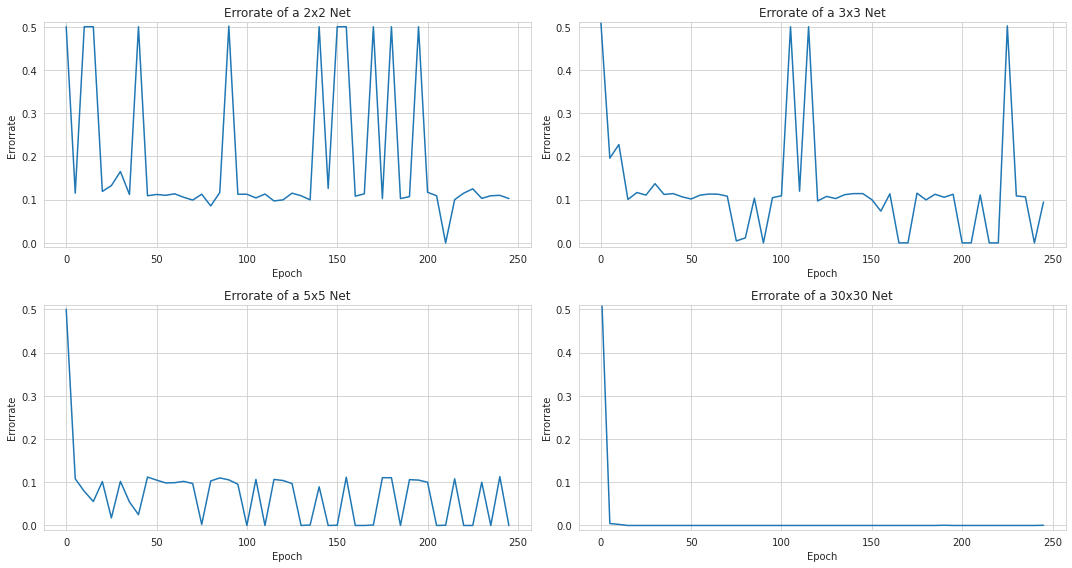

In [4]:
with sns.axes_style("whitegrid"):
    fig, ax = plt.subplots(2,2, figsize=(15.,8.))
    for i in range(4):
        key = list(error_rates.keys())[i]
        x = int(i/2)
        y = i % 2
        ax[x,y].plot(np.arange(0,250,5), error_rates[key])
        ax[x,y].set_xlabel("Epoch")
        ax[x,y].set_ylabel("Errorrate")
        ax[x,y].set_title("Errorate of a {}x{} Net".format(key,key))
        ax[x,y].set_ylim([-0.01,0.51])
        plt.tight_layout()

As one can see a larger network converges faster than smaller ones. Furthermore small networks don't seem to be converging towards zero, due to too few trainable parameters.